In [123]:
# replicates the R-GLM analysis from https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-019-0681-4

using Flux
using Gnuplot
using GLMNet
using CSV
using DataFrames
using PrettyTables
using Random
using LinearAlgebra

In [81]:
_data = DataFrame(CSV.File("regularized_glm_data.csv")) 
filter!(r -> r.bare_nuclei != "NA", _data) 
_data.bare_nuclei = parse.(Int64, _data.bare_nuclei)
_data |> pretty_table

┌─────────┬──────────┬───────────┬───────────┬────────────┬──────────┬─────────────────┬─────────────┬────────────────┬─────────────────┬─────────┬───────┐
│ Column1 │       ID │ thickness │ cell_size │ cell_shape │ adhesion │ epithelial_size │ bare_nuclei │ bland_cromatin │ normal_nucleoli │ mitoses │ class │
│   Int64 │    Int64 │     Int64 │     Int64 │      Int64 │    Int64 │           Int64 │       Int64 │          Int64 │           Int64 │   Int64 │ Int64 │
├─────────┼──────────┼───────────┼───────────┼────────────┼──────────┼─────────────────┼─────────────┼────────────────┼─────────────────┼─────────┼───────┤
│       1 │  1000025 │         5 │         1 │          1 │        1 │               2 │           1 │              3 │               1 │       1 │     2 │
│       2 │  1002945 │         5 │         4 │          4 │        5 │               7 │          10 │              3 │               2 │       1 │     2 │
│       3 │  1015425 │         3 │         1 │          1 │     

In [188]:
# sampling the test/training set 
index = 1:nrow(_data) 
testindex = rand(index, Int64(trunc(length(index)/3)))
testdf = _data[testindex, :]
traindf = _data[Not(testindex), :] 
println("testdf: $(nrow(testdf)) traindf: $(nrow(traindf))")

testdf: 227 traindf: 503


In [226]:
# using the training data, set up vectors for glmnet
y = map(x -> x == 2 ? 0 : 1, traindf[:, :class]) # convert outcmoe variable to 0/1
X = Matrix(traindf[:, 3:11])


503×9 Matrix{Int64}:
 5   1   1   1  2   1   3   1  1
 3   1   1   1  2   2   3   1  1
 4   1   1   3  2   1   3   1  1
 8  10  10   8  7  10   9   7  1
 1   1   1   1  2  10   3   1  1
 2   1   2   1  2   1   3   1  1
 2   1   1   1  2   1   1   1  5
 1   1   1   1  1   1   3   1  1
 2   1   1   1  2   1   2   1  1
 5   3   3   3  2   3   4   4  1
 8   7   5  10  7   9   5   5  4
 7   4   6   4  6   1   4   3  1
 4   1   1   1  2   1   2   1  1
 ⋮                  ⋮          
 5   1   1   1  2   1   3   2  1
 1   1   1   1  2   1   1   1  1
 1   1   1   1  2   1   1   1  1
 1   1   1   1  2   1   1   1  1
 3   1   1   1  2   1   2   3  1
 4   1   1   1  2   1   1   1  1
 5  10  10   5  4   5   4   4  1
 3   1   1   1  2   1   1   1  1
 2   1   1   1  2   1   1   1  1
 5  10  10   3  7   3   8  10  2
 4   8   6   4  3   4  10   6  1
 4   8   8   5  4   5  10   4  1

In [227]:
#path represents the Lasso or ElasticNet fits for varying values of λ. The value of the intercept for each λ value are in path.a0. The coefficients for each fit are stored in # compressed form in path.betas
path = glmnet(X, y)

Least Squares GLMNet Solution Path (56 solutions for 9 predictors in 562 passes):
──────────────────────────────
      df   pct_dev           λ
──────────────────────────────
 [1]   0  0.0       0.396544
 [2]   2  0.119928  0.361316
 [3]   3  0.232229  0.329218
 [4]   3  0.328011  0.299971
 [5]   3  0.407374  0.273323
 [6]   3  0.473246  0.249041
 [7]   4  0.531935  0.226917
 [8]   4  0.58144   0.206759
 [9]   4  0.622556  0.188391
[10]   5  0.657439  0.171655
[11]   5  0.686827  0.156405
[12]   5  0.711258  0.142511
[13]   6  0.732004  0.12985
[14]   6  0.74965   0.118315
[15]   6  0.764298  0.107804
[16]   6  0.776462  0.098227
[17]   6  0.78656   0.0895008
[18]   6  0.794948  0.0815498
[19]   6  0.801932  0.0743052
[20]   7  0.807878  0.0677041
[21]   7  0.812872  0.0616894
[22]   7  0.817023  0.0562091
[23]   7  0.820468  0.0512157
[24]   8  0.823422  0.0466658
[25]   8  0.825889  0.0425201
[26]   8  0.827939  0.0387428
[27]   8  0.829646  0.035301
[28]   8  0.831063  0.0321649
[29

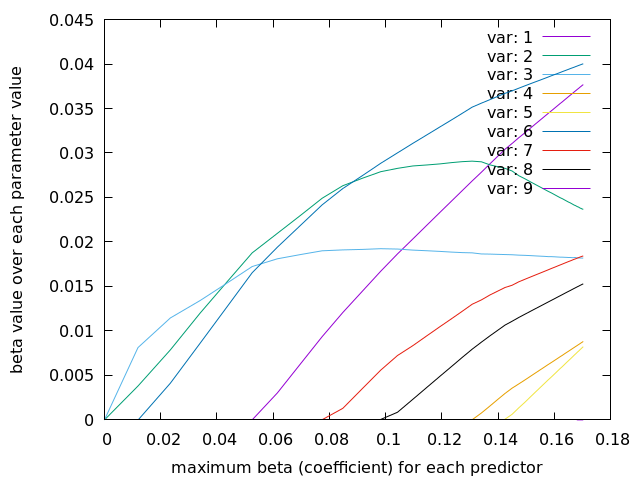

In [228]:
path.a0 # intercept values
path.betas # coefficient values

# for each solution (i.e. for each lambda value), sum up the coefficient values for all 9 predictors 
# why plot against the maximum?
betaNorm = [norm(x, 1) for x in eachslice(path.betas,dims=2)] # norm(_, 1) is sum

#@gp "reset session"
 @gp "reset"
 @gp :- "set xlabel 'maximum beta (coefficient) for each predictor'"
 @gp :- "set ylabel 'beta value over each parameter value'"
for p in 1:9 
  @gp :- betaNorm path.betas'[:, p] "title 'var: $p' with lines" :-
end
@gp


In [229]:
# To predict the output for each model along the path for a given set of predictors
yt = map(x -> x == 2 ? 0 : 1, testdf[:, :class]) # convert outcmoe variable to 0/1
Xt = Matrix(testdf[:, 3:11])
predict(path, Xt)

# here each row represents the final output of the regression over all the lambda values 
# for row[1] with 56 columns means the output of y = ax1 + ax2 + ... where each value is a continous version of y 
# and we have 56 such guesses over the 56 lambda values 
# which lambda value is best? (i.e. which row to pick)

227×56 Matrix{Float64}:
 0.353877  0.386328  0.44372   0.503262  …   1.04593      1.04626
 0.353877  0.410716  0.453347  0.491711      0.917271     0.917618
 0.353877  0.327649  0.305565  0.285718      0.192896     0.192849
 0.353877  0.327649  0.301441  0.277081      0.0204287    0.0201875
 0.353877  0.327649  0.301441  0.277081      0.0204287    0.0201875
 0.353877  0.435104  0.51247   0.583804  …   1.13276      1.13326
 0.353877  0.327649  0.305565  0.285718      0.171139     0.171075
 0.353877  0.327649  0.301441  0.277081     -0.0282683   -0.0285211
 0.353877  0.435104  0.51247   0.583804      1.17398      1.17447
 0.353877  0.327649  0.301441  0.277081     -0.0356379   -0.0359338
 0.353877  0.327649  0.301441  0.277081  …   0.103924     0.103797
 0.353877  0.327649  0.301441  0.277081     -0.0466831   -0.0469545
 0.353877  0.327649  0.301441  0.277081     -0.0282683   -0.0285211
 ⋮                                       ⋱                ⋮
 0.353877  0.331459  0.309305  0.289101  …

In [230]:
# use the training set to do n-fold cross-validation. 
cv = glmnetcv(X, y)

Least Squares GLMNet Cross Validation
56 models for 9 predictors in 10 folds
Best λ 0.005 (mean loss 0.040, std 0.004)

In [231]:
# lets get the coefficients of our betas
minloss_idx = argmin(cv.meanloss)
coef(cv) # equivalent to cv.path.betas[:, minloss_idx]


9-element Vector{Float64}:
 0.03737062760852092
 0.023831962465109012
 0.018196316041746412
 0.008553917070937056
 0.00786083254841812
 0.03988153243995555
 0.01829133409626643
 0.01509894505563303
 0.0

In [256]:
# now we know what lambda is best, pick that lambda and see the prediction accuracy on the testset

yht = round.(predict(path, Xt, outtype = :prob), digits=3);
yht[:, minloss_idx] # get the prediction from the lambda parameter that is minimized

# or alternatively, just predict using the cross fold result... they are equivalent. 
yht = round.(predict(cv, Xt, outtype = :prob), digits=4)

# Compare against the actual y values 
DataFrame(target=yt, predict=yht) |> pretty_table

┌────────┬─────────┐
│ target │ predict │
│  Int64 │ Float64 │
├────────┼─────────┤
│      1 │  1.0429 │
│      1 │  0.9142 │
│      0 │  0.1934 │
│      0 │  0.0225 │
│      0 │  0.0225 │
│      1 │  1.1285 │
│      0 │  0.1718 │
│      0 │ -0.0261 │
│      1 │  1.1697 │
│      0 │ -0.0332 │
│      0 │  0.1051 │
│      0 │ -0.0444 │
│      0 │ -0.0261 │
│      0 │ -0.0261 │
│      0 │  0.1232 │
│      0 │  0.0859 │
│      0 │  -0.007 │
│      1 │   0.884 │
│      0 │   0.104 │
│      0 │   0.697 │
│      1 │  1.0481 │
│      0 │  0.1039 │
│      1 │  0.9978 │
│      0 │  0.2463 │
│      1 │  0.8307 │
│      1 │   1.143 │
│      1 │  0.6161 │
│      1 │   0.992 │
│      1 │  0.9379 │
│      0 │  0.4714 │
│      0 │  0.0598 │
│      1 │  0.9658 │
│      1 │  0.7345 │
│      0 │   0.104 │
│      0 │  0.4714 │
│      1 │  0.5304 │
│      0 │  -0.007 │
│      0 │ -0.0523 │
│      1 │   0.794 │
│      0 │ -0.0523 │
│      0 │  0.0225 │
│      0 │  0.8309 │
│      0 │  0.0677 │
│      0 │  0

In [ ]:
#